# 付録A8: エコーチェンバーとフィルターバブル

このノートブックでは、ネットワーク上での意見の極性化や情報の偏りを生み出す「エコーチェンバー」と「フィルターバブル」について学びます。

## 学習目標

- エコーチェンバーとフィルターバブルの概念を理解する
- ホモフィリー（同類選好）によるネットワーク形成をシミュレーションする
- 意見動学モデル（DeGroot、有界信頼）を実装する
- 意見の極性化を測定・可視化する
- エコーチェンバー緩和のための介入戦略を分析する

## セットアップ

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
from collections import defaultdict
import random

plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)
random.seed(42)

## 1. エコーチェンバーとフィルターバブルとは

### 1.1 基本概念

**エコーチェンバー（Echo Chamber）**
- 同じような意見を持つ人々が集まり、その意見が反響・増幅される環境
- 自分の信念が繰り返し確認され、強化される
- 異なる視点に触れる機会が減少する

**フィルターバブル（Filter Bubble）**
- アルゴリズムによる情報のパーソナライズにより、自分の好みに合った情報のみが表示される状態
- Eli Pariser (2011) が提唱
- 検索エンジン、SNS、ニュースフィードなどで発生

### 1.2 社会的影響

| 現象 | 説明 | 例 |
|------|------|----|
| 意見の極性化 | 中間的な意見が減少し、極端な立場が増加 | 政治的二極化 |
| 確証バイアス | 自分の信念を支持する情報のみを受け入れる | フェイクニュースの拡散 |
| 集団極性化 | グループ討議後に意見がより極端になる | オンラインコミュニティ |
| 社会的分断 | 異なるグループ間の理解・対話が困難に | 政治的・文化的対立 |

/tmp/ipykernel_3838/276547615.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


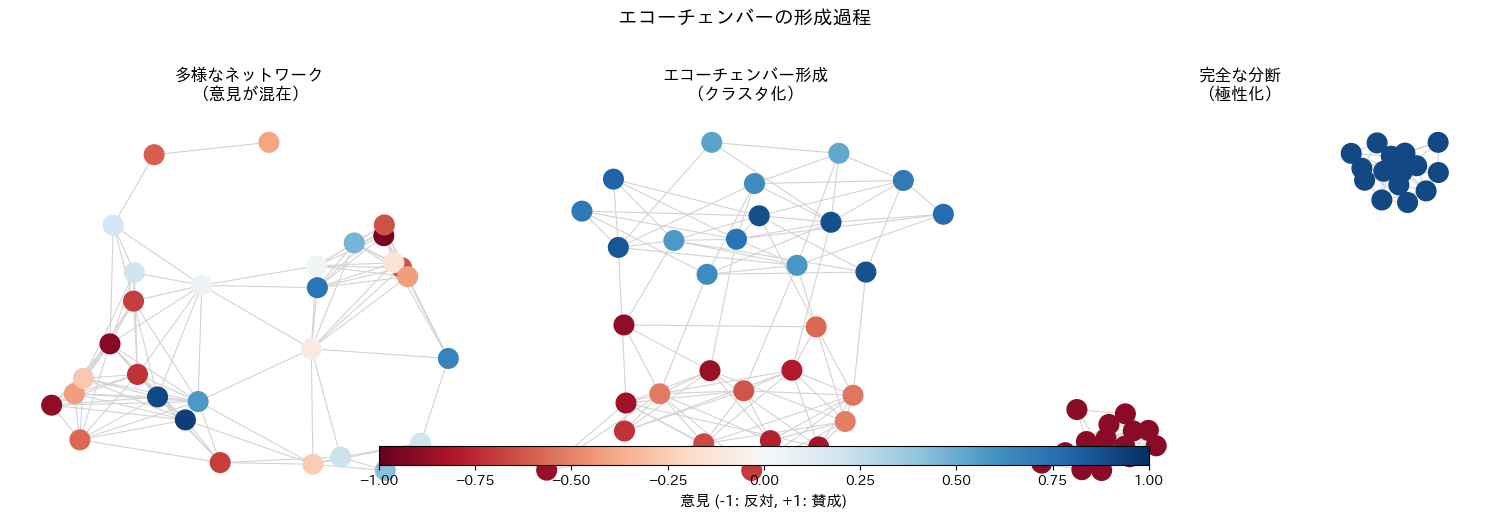

In [2]:
# エコーチェンバーの概念図
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 多様なネットワーク（エコーチェンバーなし）
ax1 = axes[0]
G1 = nx.random_geometric_graph(30, 0.35, seed=42)
pos1 = nx.get_node_attributes(G1, 'pos')
opinions1 = np.random.uniform(-1, 1, 30)
colors1 = plt.cm.RdBu((opinions1 + 1) / 2)
nx.draw(G1, pos1, ax=ax1, node_color=colors1, node_size=200,
        edge_color='lightgray', width=0.8)
ax1.set_title('多様なネットワーク\n（意見が混在）', fontsize=12)

# 2. エコーチェンバー形成中
ax2 = axes[1]
G2 = nx.Graph()
# 2つのクラスタを作成
for i in range(15):
    G2.add_node(i, opinion=-0.7 + np.random.uniform(-0.2, 0.2))
for i in range(15, 30):
    G2.add_node(i, opinion=0.7 + np.random.uniform(-0.2, 0.2))

# クラスタ内の密な接続
for i in range(15):
    for j in range(i+1, 15):
        if random.random() < 0.4:
            G2.add_edge(i, j)
for i in range(15, 30):
    for j in range(i+1, 30):
        if random.random() < 0.4:
            G2.add_edge(i, j)

# クラスタ間の疎な接続
for i in range(15):
    for j in range(15, 30):
        if random.random() < 0.05:
            G2.add_edge(i, j)

pos2 = nx.spring_layout(G2, seed=42)
opinions2 = [G2.nodes[n]['opinion'] for n in G2.nodes()]
colors2 = plt.cm.RdBu((np.array(opinions2) + 1) / 2)
nx.draw(G2, pos2, ax=ax2, node_color=colors2, node_size=200,
        edge_color='lightgray', width=0.8)
ax2.set_title('エコーチェンバー形成\n（クラスタ化）', fontsize=12)

# 3. 完全な分断
ax3 = axes[2]
G3 = nx.Graph()
for i in range(15):
    G3.add_node(i, opinion=-0.9)
for i in range(15, 30):
    G3.add_node(i, opinion=0.9)

for i in range(15):
    for j in range(i+1, 15):
        if random.random() < 0.5:
            G3.add_edge(i, j)
for i in range(15, 30):
    for j in range(i+1, 30):
        if random.random() < 0.5:
            G3.add_edge(i, j)

pos3 = nx.spring_layout(G3, seed=42)
opinions3 = [G3.nodes[n]['opinion'] for n in G3.nodes()]
colors3 = plt.cm.RdBu((np.array(opinions3) + 1) / 2)
nx.draw(G3, pos3, ax=ax3, node_color=colors3, node_size=200,
        edge_color='lightgray', width=0.8)
ax3.set_title('完全な分断\n（極性化）', fontsize=12)

# カラーバー
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=plt.Normalize(-1, 1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.1, aspect=40)
cbar.set_label('意見 (-1: 反対, +1: 賛成)', fontsize=11)

plt.suptitle('エコーチェンバーの形成過程', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 2. ホモフィリーによるネットワーク形成

### 2.1 ホモフィリー（Homophily）とは

**ホモフィリー**は「類は友を呼ぶ」という現象で、似た特性を持つ人々が結びつきやすい傾向を指します。

- **選択的ホモフィリー**: 似た人を積極的に選んでつながる
- **誘発的ホモフィリー**: つながった後に互いに似てくる

### 2.2 ホモフィリーネットワークの生成

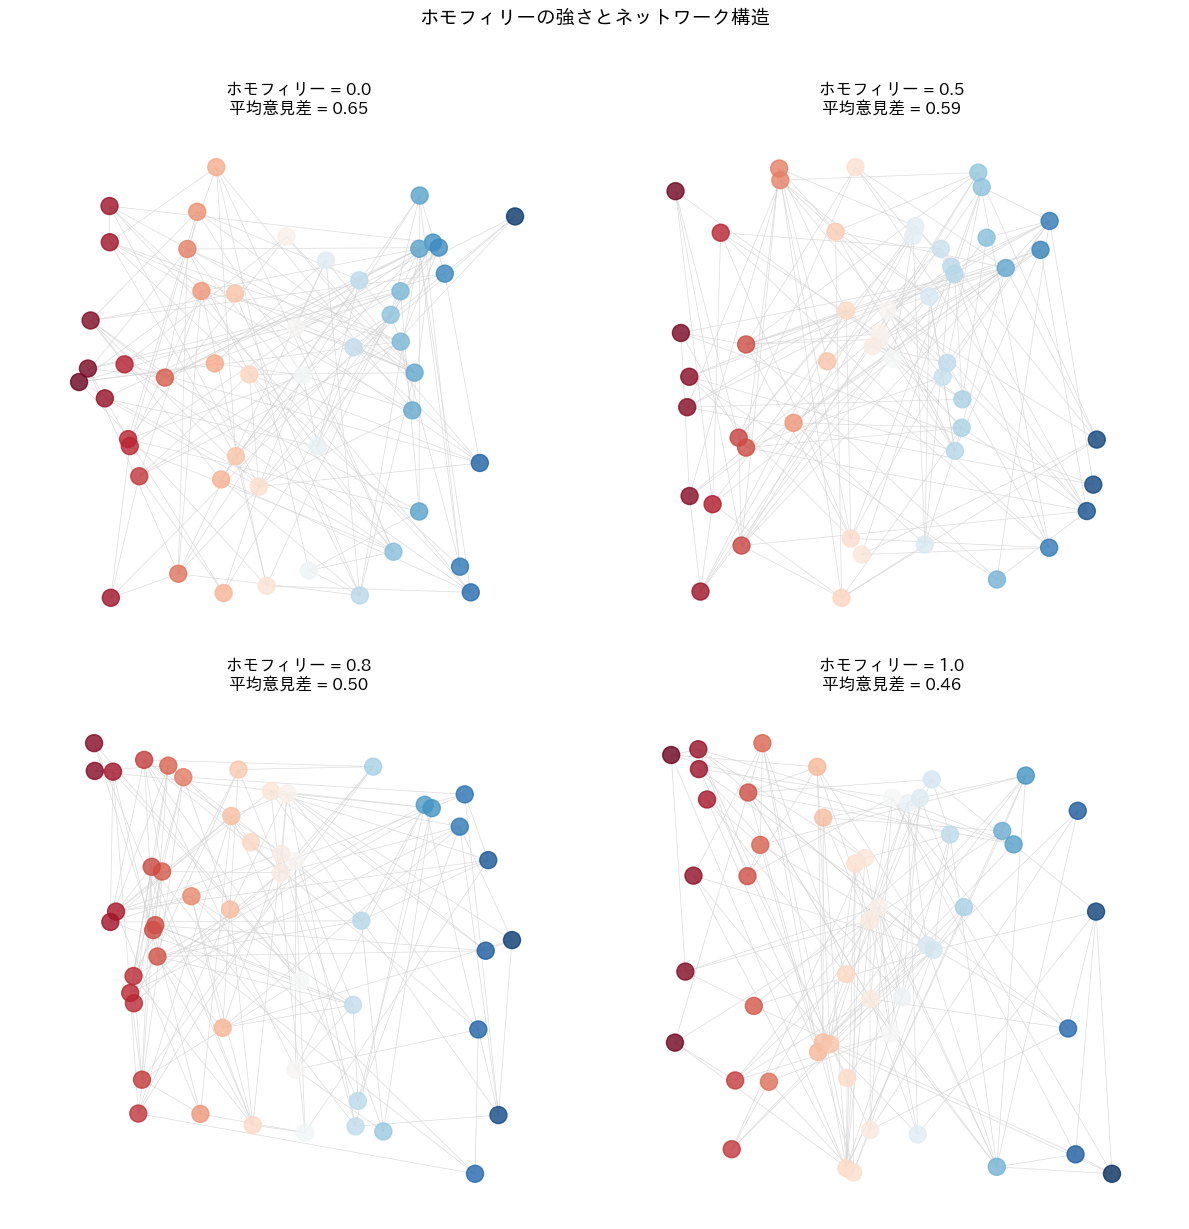

In [3]:
def create_homophily_network(n, m, homophily=0.8):
    """
    ホモフィリーに基づくネットワークを生成
    
    Parameters:
    -----------
    n : int
        ノード数
    m : int
        各ノードが追加する平均エッジ数
    homophily : float
        ホモフィリーの強さ (0-1)
        1に近いほど似た意見のノードと接続しやすい
    
    Returns:
    --------
    G : networkx.Graph
    """
    G = nx.Graph()
    
    # 各ノードに意見（-1から1）を割り当て
    for i in range(n):
        opinion = np.random.uniform(-1, 1)
        G.add_node(i, opinion=opinion)
    
    # エッジを追加
    for i in range(n):
        opinion_i = G.nodes[i]['opinion']
        
        # 接続確率を計算（意見が近いほど高い）
        probs = []
        candidates = []
        for j in range(n):
            if i != j and not G.has_edge(i, j):
                opinion_j = G.nodes[j]['opinion']
                similarity = 1 - abs(opinion_i - opinion_j) / 2  # 0-1
                # ホモフィリーに応じて確率を調整
                prob = homophily * similarity + (1 - homophily) * 0.5
                probs.append(prob)
                candidates.append(j)
        
        if candidates:
            probs = np.array(probs)
            probs /= probs.sum()
            
            # m個のエッジを追加
            n_edges = min(m, len(candidates))
            selected = np.random.choice(candidates, size=n_edges, 
                                        replace=False, p=probs)
            for j in selected:
                G.add_edge(i, j)
    
    return G

# 異なるホモフィリー強度でネットワークを生成
homophily_values = [0.0, 0.5, 0.8, 1.0]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, h in zip(axes, homophily_values):
    G = create_homophily_network(50, 3, homophily=h)
    
    # 意見に基づく位置
    pos = {}
    for node in G.nodes():
        opinion = G.nodes[node]['opinion']
        # x座標は意見、y座標はランダム
        pos[node] = (opinion, np.random.uniform(-1, 1))
    
    opinions = [G.nodes[n]['opinion'] for n in G.nodes()]
    colors = plt.cm.RdBu((np.array(opinions) + 1) / 2)
    
    nx.draw(G, pos, ax=ax, node_color=colors, node_size=150,
            edge_color='lightgray', width=0.5, alpha=0.8)
    
    # エッジの意見差の平均を計算
    edge_diffs = []
    for u, v in G.edges():
        diff = abs(G.nodes[u]['opinion'] - G.nodes[v]['opinion'])
        edge_diffs.append(diff)
    avg_diff = np.mean(edge_diffs) if edge_diffs else 0
    
    ax.set_title(f'ホモフィリー = {h}\n平均意見差 = {avg_diff:.2f}', fontsize=12)
    ax.set_xlim(-1.3, 1.3)

plt.suptitle('ホモフィリーの強さとネットワーク構造', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 2.3 ホモフィリーの測定

ネットワークにおけるホモフィリーの程度を定量化します。

In [4]:
def measure_homophily(G, attribute='opinion'):
    """
    ネットワークのホモフィリーを測定
    
    Returns:
    --------
    dict : 各種ホモフィリー指標
    """
    # エッジの意見相関
    opinions_u = []
    opinions_v = []
    for u, v in G.edges():
        opinions_u.append(G.nodes[u][attribute])
        opinions_v.append(G.nodes[v][attribute])
    
    correlation = np.corrcoef(opinions_u, opinions_v)[0, 1] if len(opinions_u) > 1 else 0
    
    # 平均意見差
    edge_diffs = [abs(G.nodes[u][attribute] - G.nodes[v][attribute]) for u, v in G.edges()]
    avg_edge_diff = np.mean(edge_diffs) if edge_diffs else 0
    
    # ランダム期待値との比較
    all_opinions = [G.nodes[n][attribute] for n in G.nodes()]
    random_diffs = []
    for _ in range(1000):
        i, j = random.sample(range(len(all_opinions)), 2)
        random_diffs.append(abs(all_opinions[i] - all_opinions[j]))
    expected_diff = np.mean(random_diffs)
    
    # ホモフィリー指数（1 - 実際の差/期待される差）
    homophily_index = 1 - avg_edge_diff / expected_diff if expected_diff > 0 else 0
    
    return {
        'correlation': correlation,
        'avg_edge_diff': avg_edge_diff,
        'expected_diff': expected_diff,
        'homophily_index': homophily_index
    }

# 異なるホモフィリー強度での測定
print("ホモフィリーの測定結果:")
print("-" * 70)
print(f"{'設定値':<10} {'相関係数':<12} {'平均意見差':<12} {'期待値':<12} {'指数':<12}")
print("-" * 70)

for h in [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]:
    G = create_homophily_network(100, 4, homophily=h)
    metrics = measure_homophily(G)
    print(f"{h:<10.1f} {metrics['correlation']:<12.3f} {metrics['avg_edge_diff']:<12.3f} "
          f"{metrics['expected_diff']:<12.3f} {metrics['homophily_index']:<12.3f}")

ホモフィリーの測定結果:
----------------------------------------------------------------------
設定値        相関係数         平均意見差        期待値          指数          
----------------------------------------------------------------------
0.0        0.006        0.688        0.677        -0.015      
0.3        0.038        0.647        0.661        0.021       
0.5        0.116        0.577        0.643        0.102       
0.7        0.247        0.528        0.619        0.147       
0.9        0.211        0.540        0.671        0.195       
1.0        0.322        0.525        0.700        0.250       


## 3. 意見動学モデル

### 3.1 DeGrootモデル

DeGrootモデル (1974) は、エージェントが隣接ノードの意見の加重平均に向かって意見を更新する古典的なモデルです。

$$x_i(t+1) = \sum_{j \in N(i)} w_{ij} x_j(t)$$

ここで $w_{ij}$ は隣接ノード $j$ への信頼度（重み）です。

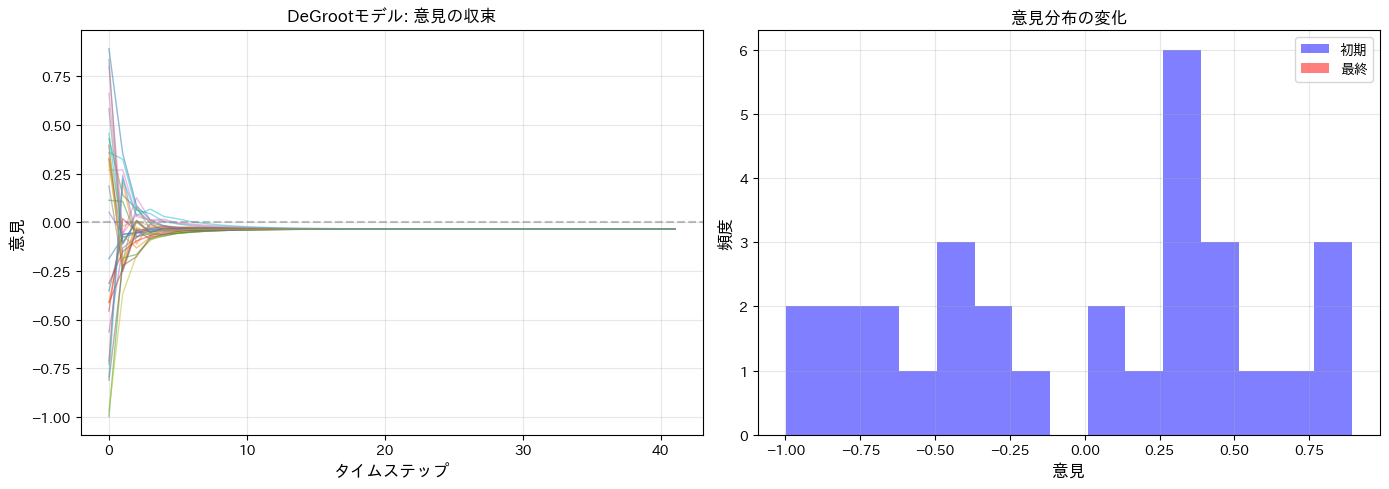

収束までのステップ数: 41
最終的な意見のばらつき: 0.0000


In [5]:
def degroot_model(G, max_steps=100, convergence_threshold=1e-6):
    """
    DeGrootモデルのシミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        各ノードに'opinion'属性を持つグラフ
    max_steps : int
        最大ステップ数
    convergence_threshold : float
        収束判定の閾値
    
    Returns:
    --------
    history : list of dict
        各ステップでの意見
    """
    opinions = {n: G.nodes[n]['opinion'] for n in G.nodes()}
    history = [opinions.copy()]
    
    for step in range(max_steps):
        new_opinions = {}
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if neighbors:
                # 自分と隣接ノードの意見の平均
                neighbor_opinions = [opinions[n] for n in neighbors]
                new_opinions[node] = (opinions[node] + sum(neighbor_opinions)) / (1 + len(neighbors))
            else:
                new_opinions[node] = opinions[node]
        
        # 収束判定
        max_change = max(abs(new_opinions[n] - opinions[n]) for n in G.nodes())
        
        opinions = new_opinions
        history.append(opinions.copy())
        
        if max_change < convergence_threshold:
            break
    
    return history

# 連結ネットワークでのDeGrootモデル
G = nx.barabasi_albert_graph(30, 2, seed=42)
for n in G.nodes():
    G.nodes[n]['opinion'] = np.random.uniform(-1, 1)

history = degroot_model(G)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 意見の時間発展
ax1 = axes[0]
for node in G.nodes():
    opinions = [h[node] for h in history]
    ax1.plot(opinions, alpha=0.5, linewidth=1)

ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('意見', fontsize=12)
ax1.set_title('DeGrootモデル: 意見の収束', fontsize=12)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

# 右: 意見分布の変化
ax2 = axes[1]
initial_opinions = list(history[0].values())
final_opinions = list(history[-1].values())

ax2.hist(initial_opinions, bins=15, alpha=0.5, label='初期', color='blue')
ax2.hist(final_opinions, bins=15, alpha=0.5, label='最終', color='red')
ax2.set_xlabel('意見', fontsize=12)
ax2.set_ylabel('頻度', fontsize=12)
ax2.set_title('意見分布の変化', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"収束までのステップ数: {len(history)-1}")
print(f"最終的な意見のばらつき: {np.std(final_opinions):.4f}")

### 3.2 有界信頼モデル（Bounded Confidence Model）

Deffuant et al. (2000) および Hegselmann-Krause (2002) による有界信頼モデルは、意見が一定範囲内の相手とのみ相互作用するモデルです。

これがエコーチェンバーの形成をよく説明します。

$$x_i(t+1) = x_i(t) + \mu \sum_{j: |x_j - x_i| < \epsilon} (x_j(t) - x_i(t))$$

- $\epsilon$: 信頼境界（この範囲内の意見のみ考慮）
- $\mu$: 収束パラメータ

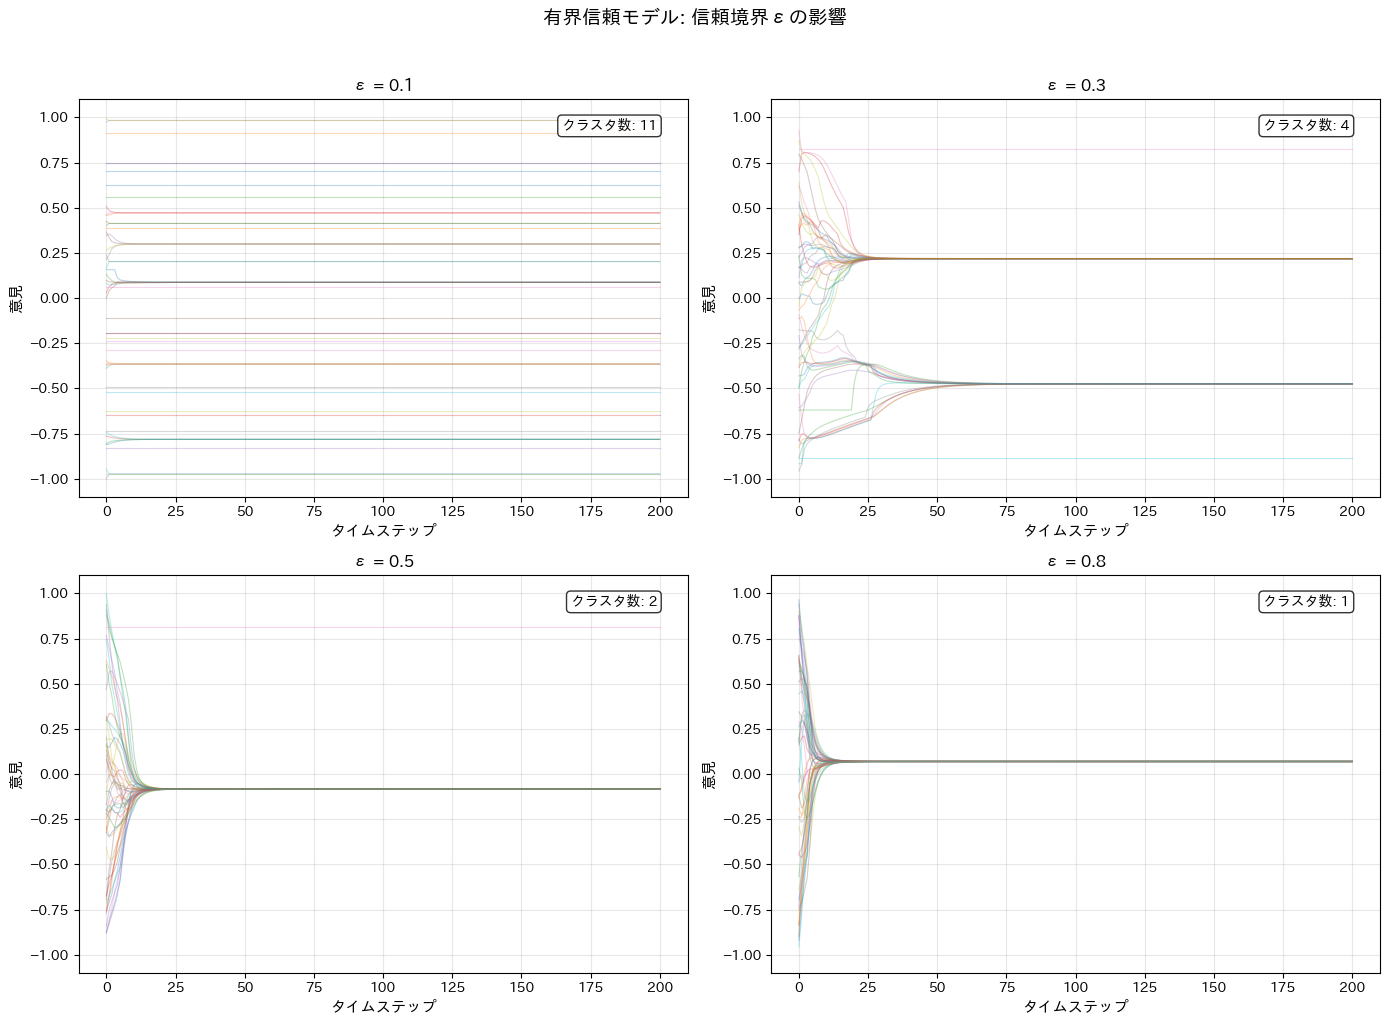

信頼境界εが小さいほど、多くの意見クラスタ（エコーチェンバー）が形成される


In [6]:
def bounded_confidence_model(G, epsilon=0.3, mu=0.5, max_steps=200):
    """
    有界信頼モデルのシミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        各ノードに'opinion'属性を持つグラフ
    epsilon : float
        信頼境界
    mu : float
        収束パラメータ
    max_steps : int
        最大ステップ数
    
    Returns:
    --------
    history : list of dict
        各ステップでの意見
    """
    opinions = {n: G.nodes[n]['opinion'] for n in G.nodes()}
    history = [opinions.copy()]
    
    for step in range(max_steps):
        new_opinions = {}
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if not neighbors:
                new_opinions[node] = opinions[node]
                continue
            
            # 信頼境界内の隣接ノードのみ考慮
            trusted_neighbors = [
                n for n in neighbors 
                if abs(opinions[n] - opinions[node]) < epsilon
            ]
            
            if trusted_neighbors:
                avg_trusted = np.mean([opinions[n] for n in trusted_neighbors])
                new_opinions[node] = opinions[node] + mu * (avg_trusted - opinions[node])
            else:
                new_opinions[node] = opinions[node]
        
        opinions = new_opinions
        history.append(opinions.copy())
    
    return history

# 異なる信頼境界でのシミュレーション
epsilon_values = [0.1, 0.3, 0.5, 0.8]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, epsilon in zip(axes, epsilon_values):
    # ネットワーク作成（完全グラフに近い）
    G = nx.watts_strogatz_graph(50, 10, 0.3, seed=42)
    for n in G.nodes():
        G.nodes[n]['opinion'] = np.random.uniform(-1, 1)
    
    history = bounded_confidence_model(G, epsilon=epsilon)
    
    # 意見の時間発展
    for node in G.nodes():
        opinions = [h[node] for h in history]
        ax.plot(opinions, alpha=0.3, linewidth=0.8)
    
    ax.set_xlabel('タイムステップ', fontsize=11)
    ax.set_ylabel('意見', fontsize=11)
    ax.set_title(f'ε = {epsilon}', fontsize=12)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True, alpha=0.3)
    
    # 最終的なクラスタ数を計算
    final_opinions = list(history[-1].values())
    clusters = []
    for op in final_opinions:
        found = False
        for c in clusters:
            if abs(op - c) < 0.1:
                found = True
                break
        if not found:
            clusters.append(op)
    ax.text(0.95, 0.95, f'クラスタ数: {len(clusters)}', 
            transform=ax.transAxes, ha='right', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('有界信頼モデル: 信頼境界εの影響', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("信頼境界εが小さいほど、多くの意見クラスタ（エコーチェンバー）が形成される")

## 4. 意見の極性化の測定

### 4.1 極性化指標

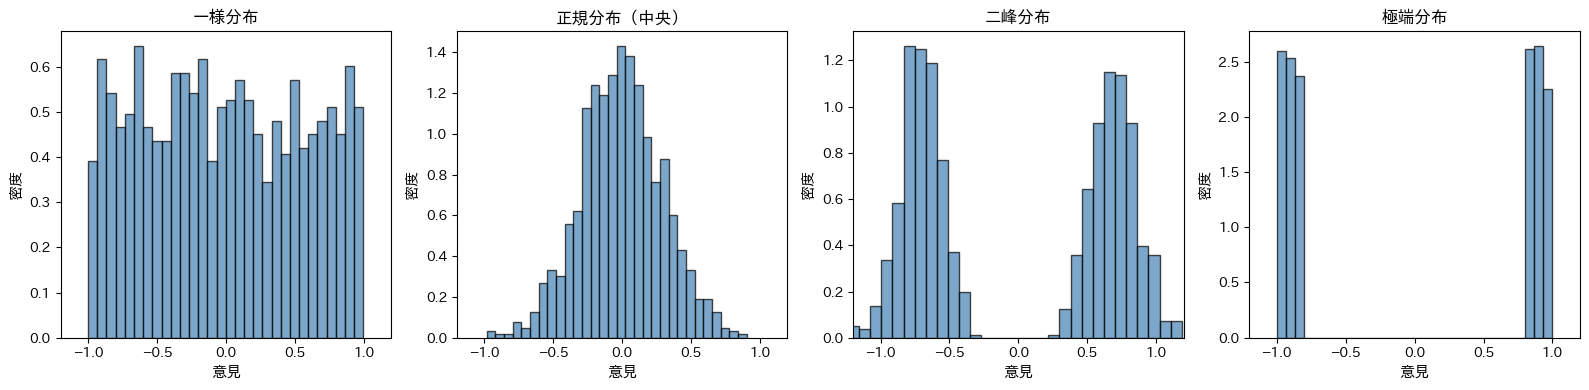


極性化指標の比較:
--------------------------------------------------------------------------------
分布              分散         双峰性        極端割合       中間割合       E-R指数     
--------------------------------------------------------------------------------
一様分布            0.334      0.553      0.306      0.305      0.067     
正規分布（中央）        0.087      0.331      0.018      0.700      0.054     
二峰分布            0.518      0.828      0.503      0.001      0.137     
極端分布            0.812      0.976      1.000      0.000      0.450     


In [7]:
def measure_polarization(opinions):
    """
    意見の極性化を測定する複数の指標
    
    Parameters:
    -----------
    opinions : list
        -1から1の範囲の意見リスト
    
    Returns:
    --------
    dict : 各種極性化指標
    """
    opinions = np.array(opinions)
    
    # 1. 分散（ばらつき）
    variance = np.var(opinions)
    
    # 2. 双峰性指数（Bimodality Coefficient）
    n = len(opinions)
    skewness = np.mean((opinions - np.mean(opinions))**3) / (np.std(opinions)**3 + 1e-10)
    kurtosis = np.mean((opinions - np.mean(opinions))**4) / (np.std(opinions)**4 + 1e-10) - 3
    bc = (skewness**2 + 1) / (kurtosis + 3 * (n-1)**2 / ((n-2)*(n-3)) + 1e-10)
    
    # 3. 極端意見の割合
    extreme_ratio = np.mean(np.abs(opinions) > 0.7)
    
    # 4. 中間意見の割合
    moderate_ratio = np.mean(np.abs(opinions) < 0.3)
    
    # 5. Esteban-Ray極性化指数（簡易版）
    # P = Σ Σ π_i^(1+α) π_j |y_i - y_j|
    bins = np.linspace(-1, 1, 11)
    hist, _ = np.histogram(opinions, bins=bins, density=True)
    hist = hist / hist.sum()  # 正規化
    centers = (bins[:-1] + bins[1:]) / 2
    
    alpha = 1.0
    er_index = 0
    for i, (pi, yi) in enumerate(zip(hist, centers)):
        for j, (pj, yj) in enumerate(zip(hist, centers)):
            er_index += (pi ** (1 + alpha)) * pj * abs(yi - yj)
    
    return {
        'variance': variance,
        'bimodality_coef': bc,
        'extreme_ratio': extreme_ratio,
        'moderate_ratio': moderate_ratio,
        'esteban_ray_index': er_index
    }

# 異なる意見分布での極性化測定
distributions = {
    '一様分布': np.random.uniform(-1, 1, 1000),
    '正規分布（中央）': np.clip(np.random.normal(0, 0.3, 1000), -1, 1),
    '二峰分布': np.concatenate([np.random.normal(-0.7, 0.15, 500),
                               np.random.normal(0.7, 0.15, 500)]),
    '極端分布': np.concatenate([np.random.uniform(-1, -0.8, 500),
                               np.random.uniform(0.8, 1, 500)])
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

results = {}
for ax, (name, opinions) in zip(axes, distributions.items()):
    ax.hist(opinions, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_xlabel('意見', fontsize=11)
    ax.set_ylabel('密度', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.set_xlim(-1.2, 1.2)
    
    metrics = measure_polarization(opinions)
    results[name] = metrics

plt.tight_layout()
plt.show()

# 指標の比較
print("\n極性化指標の比較:")
print("-" * 80)
print(f"{'分布':<15} {'分散':<10} {'双峰性':<10} {'極端割合':<10} {'中間割合':<10} {'E-R指数':<10}")
print("-" * 80)
for name, metrics in results.items():
    print(f"{name:<15} {metrics['variance']:<10.3f} {metrics['bimodality_coef']:<10.3f} "
          f"{metrics['extreme_ratio']:<10.3f} {metrics['moderate_ratio']:<10.3f} "
          f"{metrics['esteban_ray_index']:<10.3f}")

## 5. エコーチェンバーのシミュレーション

### 5.1 動的ネットワークでのエコーチェンバー形成

ノードが意見を更新しながら、同時にネットワーク構造も変化するモデルをシミュレーションします。

In [8]:
def echo_chamber_simulation(n=100, m=4, epsilon=0.3, rewiring_prob=0.1, 
                            max_steps=100, opinion_update_rate=0.3):
    """
    エコーチェンバー形成のシミュレーション
    
    ノードは：
    1. 隣接ノードの意見に影響を受けて意見を更新
    2. 意見の異なる隣接ノードとの接続を切り、似た意見のノードと接続
    
    Parameters:
    -----------
    n : int
        ノード数
    m : int
        初期エッジ数/ノード
    epsilon : float
        信頼境界
    rewiring_prob : float
        各ステップでのリワイヤリング確率
    max_steps : int
        最大ステップ数
    opinion_update_rate : float
        意見更新の強さ
    
    Returns:
    --------
    history : dict
        各種履歴データ
    G : networkx.Graph
        最終的なグラフ
    """
    # 初期ネットワーク
    G = nx.barabasi_albert_graph(n, m, seed=42)
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.uniform(-1, 1)
    
    history = {
        'opinions': [],
        'polarization': [],
        'homophily': [],
        'modularity': []
    }
    
    for step in range(max_steps):
        # 現在の状態を記録
        current_opinions = [G.nodes[n]['opinion'] for n in G.nodes()]
        history['opinions'].append(current_opinions.copy())
        history['polarization'].append(measure_polarization(current_opinions)['variance'])
        history['homophily'].append(measure_homophily(G)['homophily_index'])
        
        # モジュラリティ（意見に基づくコミュニティ）
        communities = [{n for n in G.nodes() if G.nodes[n]['opinion'] < 0},
                       {n for n in G.nodes() if G.nodes[n]['opinion'] >= 0}]
        try:
            mod = nx.community.modularity(G, communities)
        except:
            mod = 0
        history['modularity'].append(mod)
        
        # 意見の更新（有界信頼）
        new_opinions = {}
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if neighbors:
                trusted = [n for n in neighbors 
                          if abs(G.nodes[n]['opinion'] - G.nodes[node]['opinion']) < epsilon]
                if trusted:
                    avg = np.mean([G.nodes[n]['opinion'] for n in trusted])
                    new_opinions[node] = G.nodes[node]['opinion'] + \
                                         opinion_update_rate * (avg - G.nodes[node]['opinion'])
                else:
                    new_opinions[node] = G.nodes[node]['opinion']
            else:
                new_opinions[node] = G.nodes[node]['opinion']
        
        for node, op in new_opinions.items():
            G.nodes[node]['opinion'] = np.clip(op, -1, 1)
        
        # ネットワークのリワイヤリング
        edges_to_remove = []
        for u, v in G.edges():
            if random.random() < rewiring_prob:
                diff = abs(G.nodes[u]['opinion'] - G.nodes[v]['opinion'])
                if diff > epsilon:  # 意見が離れているエッジを切断候補に
                    edges_to_remove.append((u, v))
        
        for u, v in edges_to_remove:
            G.remove_edge(u, v)
            
            # 意見の近いノードと新たに接続
            candidates = [n for n in G.nodes() 
                         if n != u and not G.has_edge(u, n)
                         and abs(G.nodes[n]['opinion'] - G.nodes[u]['opinion']) < epsilon]
            if candidates:
                new_neighbor = random.choice(candidates)
                G.add_edge(u, new_neighbor)
    
    return history, G

# シミュレーション実行
history, G_final = echo_chamber_simulation(n=100, max_steps=100)

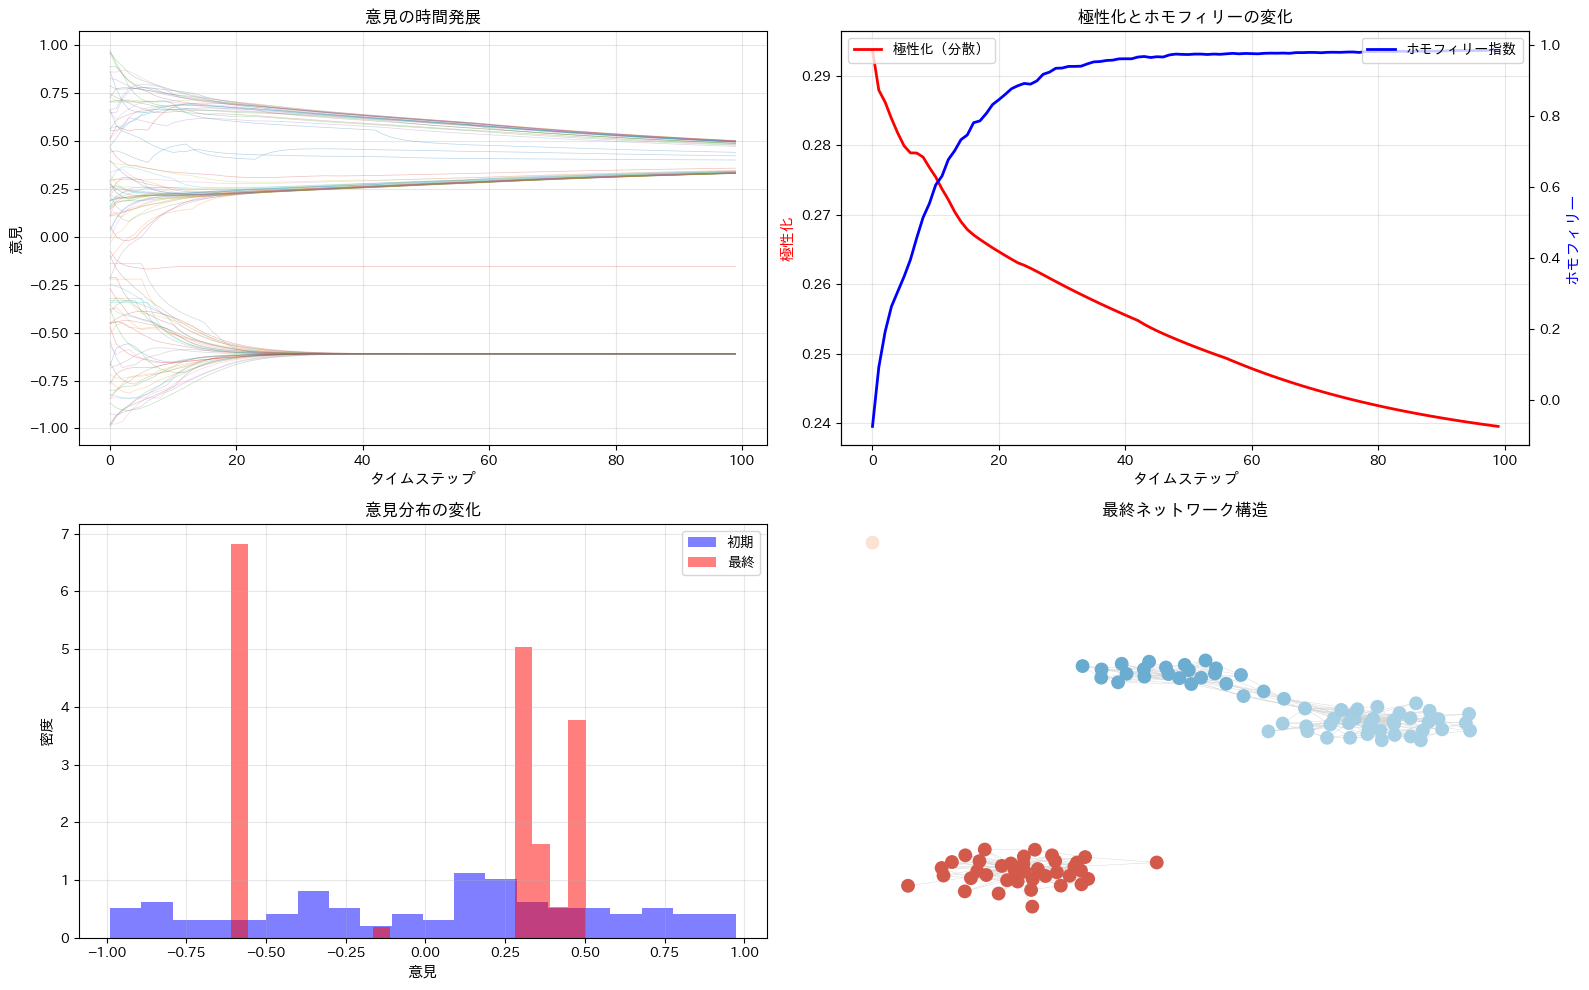


初期の極性化: 0.2937
最終の極性化: 0.2396
初期のホモフィリー: -0.0751
最終のホモフィリー: 0.9861


In [9]:
# 結果の可視化
fig = plt.figure(figsize=(16, 10))

# 1. 意見の時間発展
ax1 = fig.add_subplot(2, 2, 1)
opinions_array = np.array(history['opinions'])
for i in range(opinions_array.shape[1]):
    ax1.plot(opinions_array[:, i], alpha=0.3, linewidth=0.5)
ax1.set_xlabel('タイムステップ', fontsize=11)
ax1.set_ylabel('意見', fontsize=11)
ax1.set_title('意見の時間発展', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. 極性化とホモフィリーの推移
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(history['polarization'], label='極性化（分散）', color='red', linewidth=2)
ax2_twin = ax2.twinx()
ax2_twin.plot(history['homophily'], label='ホモフィリー指数', color='blue', linewidth=2)
ax2.set_xlabel('タイムステップ', fontsize=11)
ax2.set_ylabel('極性化', color='red', fontsize=11)
ax2_twin.set_ylabel('ホモフィリー', color='blue', fontsize=11)
ax2.set_title('極性化とホモフィリーの変化', fontsize=12)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. 意見分布の変化
ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(history['opinions'][0], bins=20, alpha=0.5, label='初期', color='blue', density=True)
ax3.hist(history['opinions'][-1], bins=20, alpha=0.5, label='最終', color='red', density=True)
ax3.set_xlabel('意見', fontsize=11)
ax3.set_ylabel('密度', fontsize=11)
ax3.set_title('意見分布の変化', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 最終ネットワークの可視化
ax4 = fig.add_subplot(2, 2, 4)
pos = nx.spring_layout(G_final, seed=42)
opinions = [G_final.nodes[n]['opinion'] for n in G_final.nodes()]
colors = plt.cm.RdBu((np.array(opinions) + 1) / 2)
nx.draw(G_final, pos, ax=ax4, node_color=colors, node_size=80,
        edge_color='lightgray', width=0.3)
ax4.set_title('最終ネットワーク構造', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n初期の極性化: {history['polarization'][0]:.4f}")
print(f"最終の極性化: {history['polarization'][-1]:.4f}")
print(f"初期のホモフィリー: {history['homophily'][0]:.4f}")
print(f"最終のホモフィリー: {history['homophily'][-1]:.4f}")

## 6. エコーチェンバー緩和戦略

### 6.1 介入戦略の比較

エコーチェンバーを緩和するための様々な戦略を比較します。

In [10]:
def apply_intervention(G, strategy='random_bridges', n_bridges=10):
    """
    エコーチェンバー緩和のための介入を適用
    
    Parameters:
    -----------
    G : networkx.Graph
        介入対象のグラフ
    strategy : str
        介入戦略
    n_bridges : int
        追加するブリッジの数
    
    Returns:
    --------
    G : networkx.Graph
        介入後のグラフ
    """
    G = G.copy()
    
    if strategy == 'random_bridges':
        # ランダムに異なる意見グループ間にブリッジを追加
        positive = [n for n in G.nodes() if G.nodes[n]['opinion'] >= 0]
        negative = [n for n in G.nodes() if G.nodes[n]['opinion'] < 0]
        
        for _ in range(n_bridges):
            if positive and negative:
                u = random.choice(positive)
                v = random.choice(negative)
                if not G.has_edge(u, v):
                    G.add_edge(u, v)
    
    elif strategy == 'hub_bridges':
        # 各グループのハブ間にブリッジを追加
        positive = [n for n in G.nodes() if G.nodes[n]['opinion'] >= 0]
        negative = [n for n in G.nodes() if G.nodes[n]['opinion'] < 0]
        
        pos_hubs = sorted(positive, key=lambda x: G.degree(x), reverse=True)[:n_bridges]
        neg_hubs = sorted(negative, key=lambda x: G.degree(x), reverse=True)[:n_bridges]
        
        for u, v in zip(pos_hubs, neg_hubs):
            if not G.has_edge(u, v):
                G.add_edge(u, v)
    
    elif strategy == 'moderate_amplify':
        # 中間的な意見を持つノードの接続を強化
        moderates = [n for n in G.nodes() if abs(G.nodes[n]['opinion']) < 0.3]
        
        for moderate in moderates[:n_bridges]:
            # 両極端のノードと接続
            extremes = [n for n in G.nodes() 
                       if abs(G.nodes[n]['opinion']) > 0.7 and not G.has_edge(moderate, n)]
            if extremes:
                target = random.choice(extremes)
                G.add_edge(moderate, target)
    
    return G

def run_intervention_experiment(n_trials=20):
    """
    介入実験を実行
    """
    strategies = ['none', 'random_bridges', 'hub_bridges', 'moderate_amplify']
    results = {s: {'polarization': [], 'homophily': []} for s in strategies}
    
    for trial in range(n_trials):
        # まずエコーチェンバーを形成
        _, G_echo = echo_chamber_simulation(n=80, max_steps=50, 
                                           epsilon=0.25, rewiring_prob=0.15)
        
        for strategy in strategies:
            G = G_echo.copy()
            
            if strategy != 'none':
                G = apply_intervention(G, strategy=strategy, n_bridges=8)
            
            # 介入後のダイナミクスを実行
            for _ in range(30):
                new_opinions = {}
                for node in G.nodes():
                    neighbors = list(G.neighbors(node))
                    if neighbors:
                        avg = np.mean([G.nodes[n]['opinion'] for n in neighbors])
                        new_opinions[node] = G.nodes[node]['opinion'] + 0.2 * (avg - G.nodes[node]['opinion'])
                    else:
                        new_opinions[node] = G.nodes[node]['opinion']
                
                for node, op in new_opinions.items():
                    G.nodes[node]['opinion'] = np.clip(op, -1, 1)
            
            # 結果を記録
            opinions = [G.nodes[n]['opinion'] for n in G.nodes()]
            results[strategy]['polarization'].append(np.var(opinions))
            results[strategy]['homophily'].append(measure_homophily(G)['homophily_index'])
    
    return results

print("介入実験を実行中...")
intervention_results = run_intervention_experiment(n_trials=15)

介入実験を実行中...


/tmp/ipykernel_3838/592024613.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_pol, labels=[strategy_names[s] for s in strategy_names.keys()],
/tmp/ipykernel_3838/592024613.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_hom, labels=[strategy_names[s] for s in strategy_names.keys()],


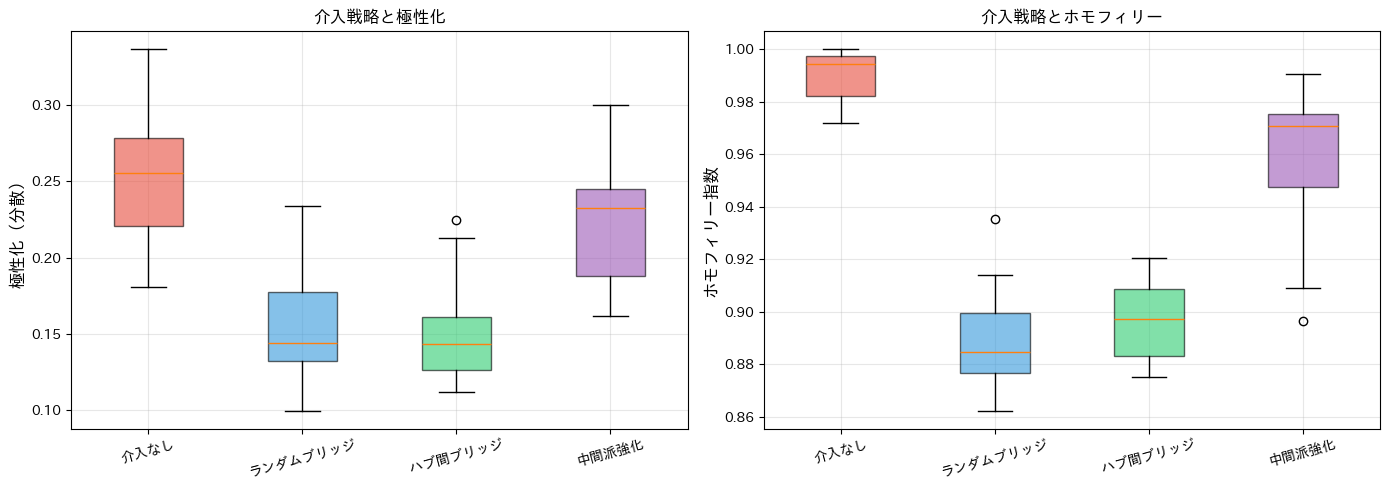


介入効果の比較:
------------------------------------------------------------
戦略                   極性化                  ホモフィリー              
------------------------------------------------------------
介入なし                 0.251 ± 0.041      0.990 ± 0.009
ランダムブリッジ             0.155 ± 0.035      0.889 ± 0.018
ハブ間ブリッジ              0.150 ± 0.032      0.897 ± 0.015
中間派強化                0.221 ± 0.039      0.958 ± 0.029


In [11]:
# 介入結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strategy_names = {
    'none': '介入なし',
    'random_bridges': 'ランダムブリッジ',
    'hub_bridges': 'ハブ間ブリッジ',
    'moderate_amplify': '中間派強化'
}

# 極性化の比較
ax1 = axes[0]
data_pol = [intervention_results[s]['polarization'] for s in strategy_names.keys()]
bp1 = ax1.boxplot(data_pol, labels=[strategy_names[s] for s in strategy_names.keys()], 
                  patch_artist=True)
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax1.set_ylabel('極性化（分散）', fontsize=12)
ax1.set_title('介入戦略と極性化', fontsize=12)
ax1.tick_params(axis='x', rotation=15)
ax1.grid(True, alpha=0.3)

# ホモフィリーの比較
ax2 = axes[1]
data_hom = [intervention_results[s]['homophily'] for s in strategy_names.keys()]
bp2 = ax2.boxplot(data_hom, labels=[strategy_names[s] for s in strategy_names.keys()],
                  patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel('ホモフィリー指数', fontsize=12)
ax2.set_title('介入戦略とホモフィリー', fontsize=12)
ax2.tick_params(axis='x', rotation=15)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 数値結果
print("\n介入効果の比較:")
print("-" * 60)
print(f"{'戦略':<20} {'極性化':<20} {'ホモフィリー':<20}")
print("-" * 60)
for s, name in strategy_names.items():
    pol_mean = np.mean(intervention_results[s]['polarization'])
    pol_std = np.std(intervention_results[s]['polarization'])
    hom_mean = np.mean(intervention_results[s]['homophily'])
    hom_std = np.std(intervention_results[s]['homophily'])
    print(f"{name:<20} {pol_mean:.3f} ± {pol_std:.3f}      {hom_mean:.3f} ± {hom_std:.3f}")

## 7. 情報多様性の分析

### 7.1 情報露出の多様性

/tmp/ipykernel_3838/1438267435.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


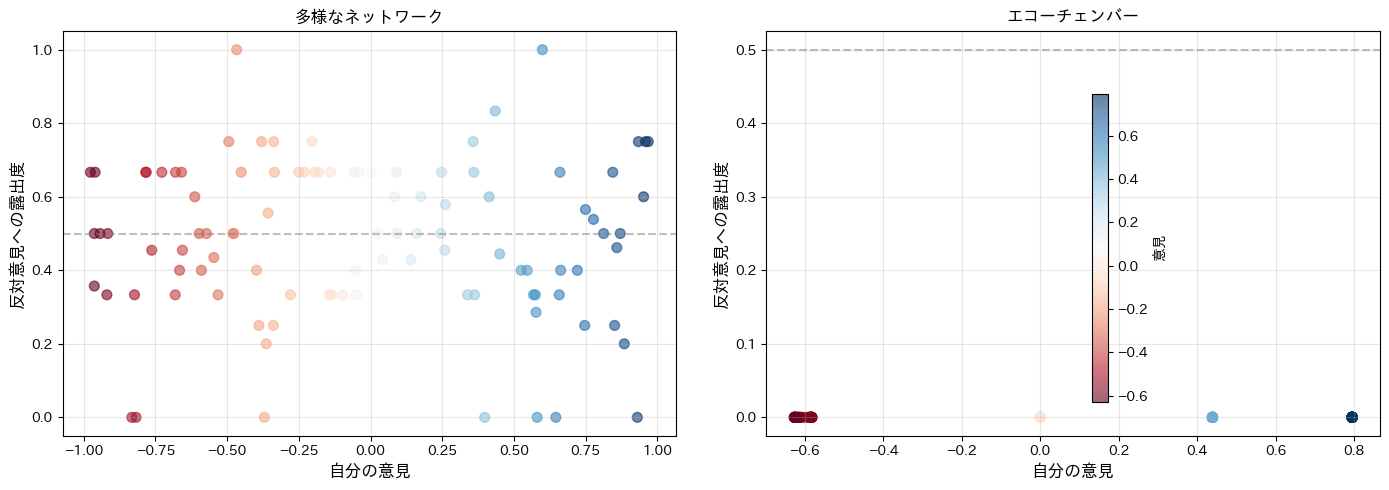


反対意見への露出度:
  多様なネットワーク: 0.487 ± 0.212
  エコーチェンバー:   0.000 ± 0.000


In [12]:
def measure_information_diversity(G):
    """
    各ノードが露出する情報の多様性を測定
    
    Returns:
    --------
    diversity_scores : dict
        各ノードの情報多様性スコア
    """
    diversity_scores = {}
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if not neighbors:
            diversity_scores[node] = 0
            continue
        
        # 隣接ノードの意見の多様性（標準偏差）
        neighbor_opinions = [G.nodes[n]['opinion'] for n in neighbors]
        diversity = np.std(neighbor_opinions) if len(neighbor_opinions) > 1 else 0
        
        # 自分の意見と隣接ノードの意見の差の範囲
        own_opinion = G.nodes[node]['opinion']
        opinion_range = max(neighbor_opinions) - min(neighbor_opinions) if neighbor_opinions else 0
        
        # 反対意見への露出度
        opposite_exposure = sum(1 for op in neighbor_opinions 
                               if own_opinion * op < 0) / len(neighbor_opinions)
        
        diversity_scores[node] = {
            'std': diversity,
            'range': opinion_range,
            'opposite_exposure': opposite_exposure
        }
    
    return diversity_scores

# エコーチェンバーありとなしでの比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# エコーチェンバーなし（ランダムネットワーク）
G_random = nx.barabasi_albert_graph(100, 3, seed=42)
for n in G_random.nodes():
    G_random.nodes[n]['opinion'] = np.random.uniform(-1, 1)

# エコーチェンバーあり
_, G_echo = echo_chamber_simulation(n=100, max_steps=80, epsilon=0.2)

# 多様性の測定
div_random = measure_information_diversity(G_random)
div_echo = measure_information_diversity(G_echo)

# ランダムネットワーク
ax1 = axes[0]
opposite_exp_random = [d['opposite_exposure'] for d in div_random.values()]
opinions_random = [G_random.nodes[n]['opinion'] for n in G_random.nodes()]
scatter1 = ax1.scatter(opinions_random, opposite_exp_random, 
                       c=opinions_random, cmap='RdBu', alpha=0.6, s=50)
ax1.set_xlabel('自分の意見', fontsize=12)
ax1.set_ylabel('反対意見への露出度', fontsize=12)
ax1.set_title('多様なネットワーク', fontsize=12)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

# エコーチェンバー
ax2 = axes[1]
opposite_exp_echo = [d['opposite_exposure'] for d in div_echo.values()]
opinions_echo = [G_echo.nodes[n]['opinion'] for n in G_echo.nodes()]
scatter2 = ax2.scatter(opinions_echo, opposite_exp_echo,
                       c=opinions_echo, cmap='RdBu', alpha=0.6, s=50)
ax2.set_xlabel('自分の意見', fontsize=12)
ax2.set_ylabel('反対意見への露出度', fontsize=12)
ax2.set_title('エコーチェンバー', fontsize=12)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.colorbar(scatter2, ax=axes, label='意見', shrink=0.8)
plt.tight_layout()
plt.show()

print(f"\n反対意見への露出度:")
print(f"  多様なネットワーク: {np.mean(opposite_exp_random):.3f} ± {np.std(opposite_exp_random):.3f}")
print(f"  エコーチェンバー:   {np.mean(opposite_exp_echo):.3f} ± {np.std(opposite_exp_echo):.3f}")

## 8. まとめ

### 主要な概念

| 概念 | 説明 | ネットワーク的特徴 |
|------|------|--------------------|
| エコーチェンバー | 同じ意見が反響・増幅される環境 | 高クラスタリング、低橋渡し |
| フィルターバブル | アルゴリズムによる情報の偏り | パーソナライズされた情報露出 |
| ホモフィリー | 類は友を呼ぶ | 意見類似ノード間の高接続率 |
| 意見極性化 | 中間意見の減少、極端化 | 分断されたコミュニティ構造 |

### 重要なポイント

1. **ホモフィリーとネットワーク形成**: 似た意見を持つ人同士がつながりやすく、これがエコーチェンバーの基盤となる

2. **有界信頼モデル**: 信頼境界が小さいほど、より多くの意見クラスタ（エコーチェンバー）が形成される

3. **動的プロセス**: 意見更新とネットワーク再構成が同時に起こることで、極性化が加速する

4. **介入戦略**: 
   - 異なるグループ間のブリッジ構築
   - 中間的意見を持つノードの影響力強化
   - ハブノードを通じた情報の多様化

### 実務への応用

- **SNSプラットフォーム設計**: 情報多様性を促進するアルゴリズム
- **フェイクニュース対策**: エコーチェンバー内での誤情報拡散の抑制
- **社会的分断の緩和**: 異なるコミュニティ間の対話促進
- **民主主義の健全性**: 多様な視点への露出を確保

---

## 練習問題

### 問題1: ホモフィリーネットワークの分析

ホモフィリー強度を0.0, 0.5, 1.0の3段階で変化させたネットワーク（各100ノード、平均次数6）を生成し、以下を比較してください：
1. 平均クラスタリング係数
2. 意見に基づく2グループでのモジュラリティ
3. グループ間エッジの割合

<details>
<summary>解答例</summary>

```python
homophily_levels = [0.0, 0.5, 1.0]
results = []

for h in homophily_levels:
    G = create_homophily_network(100, 3, homophily=h)
    
    # クラスタリング係数
    clustering = nx.average_clustering(G)
    
    # モジュラリティ（意見で2グループに分割）
    positive = {n for n in G.nodes() if G.nodes[n]['opinion'] >= 0}
    negative = {n for n in G.nodes() if G.nodes[n]['opinion'] < 0}
    modularity = nx.community.modularity(G, [positive, negative])
    
    # グループ間エッジの割合
    cross_edges = sum(1 for u, v in G.edges() 
                     if (u in positive and v in negative) or 
                        (u in negative and v in positive))
    cross_ratio = cross_edges / G.number_of_edges()
    
    results.append({
        'homophily': h,
        'clustering': clustering,
        'modularity': modularity,
        'cross_edge_ratio': cross_ratio
    })

# 結果表示
print(f"{'ホモフィリー':<12} {'クラスタリング':<15} {'モジュラリティ':<15} {'グループ間エッジ':<15}")
print("-" * 60)
for r in results:
    print(f"{r['homophily']:<12.1f} {r['clustering']:<15.3f} {r['modularity']:<15.3f} {r['cross_edge_ratio']:<15.3f}")
```

</details>

### 問題2: 信頼境界と極性化

有界信頼モデルにおいて、信頼境界εを0.1から0.5まで0.1刻みで変化させ、各設定で20回シミュレーションを実行してください。最終的な意見クラスタ数と極性化（分散）の関係をグラフで示してください。

<details>
<summary>解答例</summary>

```python
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5]
n_trials = 20

results = {eps: {'n_clusters': [], 'polarization': []} for eps in epsilon_values}

for eps in epsilon_values:
    for _ in range(n_trials):
        G = nx.watts_strogatz_graph(50, 8, 0.3)
        for n in G.nodes():
            G.nodes[n]['opinion'] = np.random.uniform(-1, 1)
        
        history = bounded_confidence_model(G, epsilon=eps, max_steps=150)
        final_opinions = list(history[-1].values())
        
        # クラスタ数のカウント
        clusters = []
        for op in final_opinions:
            found = False
            for c in clusters:
                if abs(op - c) < 0.1:
                    found = True
                    break
            if not found:
                clusters.append(op)
        
        results[eps]['n_clusters'].append(len(clusters))
        results[eps]['polarization'].append(np.var(final_opinions))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
means = [np.mean(results[eps]['n_clusters']) for eps in epsilon_values]
stds = [np.std(results[eps]['n_clusters']) for eps in epsilon_values]
ax1.errorbar(epsilon_values, means, yerr=stds, fmt='o-', capsize=5)
ax1.set_xlabel('信頼境界 ε')
ax1.set_ylabel('意見クラスタ数')
ax1.set_title('信頼境界とクラスタ数')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
means = [np.mean(results[eps]['polarization']) for eps in epsilon_values]
stds = [np.std(results[eps]['polarization']) for eps in epsilon_values]
ax2.errorbar(epsilon_values, means, yerr=stds, fmt='o-', capsize=5, color='red')
ax2.set_xlabel('信頼境界 ε')
ax2.set_ylabel('極性化（分散）')
ax2.set_title('信頼境界と極性化')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

</details>

### 問題3: 介入タイミングの効果

エコーチェンバー形成シミュレーションにおいて、介入（ランダムブリッジ10本追加）のタイミングを変えた場合の効果を分析してください：
1. 早期介入（20ステップ目）
2. 中期介入（50ステップ目）
3. 後期介入（80ステップ目）

各タイミングで15回実験を行い、最終的な極性化を比較してください。

<details>
<summary>解答例</summary>

```python
def simulation_with_intervention(intervention_step):
    """指定ステップで介入を行うシミュレーション"""
    n, m = 80, 3
    epsilon, rewiring_prob = 0.25, 0.1
    
    G = nx.barabasi_albert_graph(n, m, seed=None)
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.uniform(-1, 1)
    
    for step in range(100):
        # 介入
        if step == intervention_step:
            positive = [n for n in G.nodes() if G.nodes[n]['opinion'] >= 0]
            negative = [n for n in G.nodes() if G.nodes[n]['opinion'] < 0]
            for _ in range(10):
                if positive and negative:
                    u, v = random.choice(positive), random.choice(negative)
                    if not G.has_edge(u, v):
                        G.add_edge(u, v)
        
        # 意見更新
        new_opinions = {}
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if neighbors:
                trusted = [n for n in neighbors 
                          if abs(G.nodes[n]['opinion'] - G.nodes[node]['opinion']) < epsilon]
                if trusted:
                    avg = np.mean([G.nodes[n]['opinion'] for n in trusted])
                    new_opinions[node] = G.nodes[node]['opinion'] + 0.3 * (avg - G.nodes[node]['opinion'])
                else:
                    new_opinions[node] = G.nodes[node]['opinion']
            else:
                new_opinions[node] = G.nodes[node]['opinion']
        
        for node, op in new_opinions.items():
            G.nodes[node]['opinion'] = np.clip(op, -1, 1)
        
        # リワイヤリング
        edges_to_remove = [(u, v) for u, v in G.edges() 
                          if random.random() < rewiring_prob and 
                          abs(G.nodes[u]['opinion'] - G.nodes[v]['opinion']) > epsilon]
        for u, v in edges_to_remove:
            G.remove_edge(u, v)
            candidates = [n for n in G.nodes() if n != u and not G.has_edge(u, n) and
                         abs(G.nodes[n]['opinion'] - G.nodes[u]['opinion']) < epsilon]
            if candidates:
                G.add_edge(u, random.choice(candidates))
    
    return np.var([G.nodes[n]['opinion'] for n in G.nodes()])

# 実験
timings = {'早期 (20)': 20, '中期 (50)': 50, '後期 (80)': 80, '介入なし': 999}
n_trials = 15

results = {name: [] for name in timings.keys()}
for name, step in timings.items():
    for _ in range(n_trials):
        pol = simulation_with_intervention(step)
        results[name].append(pol)

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(results.values(), labels=results.keys(), patch_artist=True)
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#95a5a6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('最終極性化（分散）')
ax.set_title('介入タイミングと極性化')
ax.grid(True, alpha=0.3)
plt.show()

print("\n結果:")
for name, vals in results.items():
    print(f"{name}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")
```

</details>

---

## 参考文献

- Pariser, E. (2011). The Filter Bubble: What the Internet Is Hiding from You. Penguin Press.
- Deffuant, G., et al. (2000). Mixing beliefs among interacting agents. Advances in Complex Systems.
- Hegselmann, R., & Krause, U. (2002). Opinion dynamics and bounded confidence models, analysis, and simulation. JASSS.
- McPherson, M., Smith-Lovin, L., & Cook, J. M. (2001). Birds of a feather: Homophily in social networks. Annual Review of Sociology.
- Sunstein, C. R. (2001). Echo Chambers: Bush v. Gore, Impeachment, and Beyond. Princeton University Press.